In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from kmodes.kmodes import KModes
from kneed import KneeLocator
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist
from sklearn.cluster import DBSCAN
from sklearn.metrics import davies_bouldin_score, silhouette_score
import hdbscan
from hdbscan.prediction import approximate_predict
from skopt import gp_minimize
from skopt.space import Integer
from skopt.utils import use_named_args
from sklearn.decomposition import PCA

sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Set random seed for reproducibility
np.random.seed(2025)

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

# Data Preprocessing & Feature Engineering

In [4]:
def load_and_preprocess_data(file_path="/content/Original_Data.csv"):
    print("Loading and preprocessing data...")

    # Load the data with error handling
    try:
        df_full = pd.read_csv(file_path, on_bad_lines='skip', dtype=str)  # Read all columns as strings first
        print("File loaded successfully, skipping bad lines if necessary.")
    except pd.errors.ParserError as e:
        print(f"Critical error reading CSV: {e}")
        return None  # Exit function if loading completely fails

    # Convert date columns to datetime
    date_cols = ["ScheduledDay", "AppointmentDay"]
    for col in date_cols:
        if col in df_full.columns:
            df_full[col] = pd.to_datetime(df_full[col], errors='coerce')
        else:
            print(f"Warning: {col} column is missing!")

    # Fix binary categorical columns (handle "Yes"/"No" and convert to int)
    binary_cols = ["Alcoholism", "Diabetes", "Hipertension", "Handcap", "SMS_received"]
    for col in binary_cols:
        if col in df_full.columns:
            df_full[col] = df_full[col].replace({"Yes": 1, "No": 0})  # Convert Yes/No to 1/0
            df_full[col] = pd.to_numeric(df_full[col], errors='coerce').fillna(0).astype(int)  # Ensure integers

    # Convert target variable 'No-show' to binary
    if "No-show" in df_full.columns:
        df_full['No-show'] = df_full['No-show'].map({'Yes': 1, 'No': 0}).fillna(0)
    else:
        print("Warning: 'No-show' column is missing!")

    # Compute non-negative WaitTime in days
    if all(col in df_full.columns for col in date_cols):
        df_full['WaitTime'] = (df_full['AppointmentDay'] - df_full['ScheduledDay']).dt.days.clip(lower=0).fillna(0)
        df_full['WaitTime_Log'] = np.log1p(df_full['WaitTime'])
        print("Skewness before log transformation:", df_full['WaitTime'].skew())
        print("Skewness after log transformation:", df_full['WaitTime_Log'].skew())

    # Encode Gender
    if "Gender" in df_full.columns:
        df_full['Gender_Encoded'] = df_full['Gender'].map({'F': 1, 'M': 0}).fillna(-1)

    # Extract month and weekday features
    for col in ["ScheduledDay", "AppointmentDay"]:
        if col in df_full.columns:
            df_full[f"{col}_Month"] = df_full[col].dt.month.astype("category")
            df_full[f"{col}_Weekday"] = df_full[col].dt.day_name()

    # One-hot encode 'Neighbourhood'
    if 'Neighbourhood' in df_full.columns:
        df_full = pd.get_dummies(df_full, columns=['Neighbourhood'], prefix='NB', drop_first=True)
        print("One-hot encoding applied for 'Neighbourhood'.")
    else:
        print("Warning: 'Neighbourhood' column is missing!")

    return df_full

In [5]:
df_full = load_and_preprocess_data("/content/Original_Data.csv")
df_full.head()

Loading and preprocessing data...
File loaded successfully, skipping bad lines if necessary.
Skewness before log transformation: 2.7479832567869322
Skewness after log transformation: 0.35290499104678574
One-hot encoding applied for 'Neighbourhood'.


,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,WaitTime,WaitTime_Log,Gender_Encoded,ScheduledDay_Month,ScheduledDay_Weekday,AppointmentDay_Month,AppointmentDay_Weekday,NB_ANDORINHAS,NB_ANTÔNIO HONÓRIO,NB_ARIOVALDO FAVALESSA,NB_BARRO VERMELHO,NB_BELA VISTA,NB_BENTO FERREIRA,NB_BOA VISTA,NB_BONFIM,NB_CARATOÍRA,NB_CENTRO,NB_COMDUSA,NB_CONQUISTA,NB_CONSOLAÇÃO,NB_CRUZAMENTO,NB_DA PENHA,NB_DE LOURDES,NB_DO CABRAL,NB_DO MOSCOSO,NB_DO QUADRO,NB_ENSEADA DO SUÁ,NB_ESTRELINHA,NB_FONTE GRANDE,NB_FORTE SÃO JOÃO,NB_FRADINHOS,NB_GOIABEIRAS,NB_GRANDE VITÓRIA,NB_GURIGICA,NB_HORTO,NB_ILHA DAS CAIEIRAS,NB_ILHA DE SANTA MARIA,NB_ILHA DO BOI,NB_ILHA DO FRADE,NB_ILHA DO PRÍNCIPE,NB_ILHAS OCEÂNICAS DE TRINDADE,NB_INHANGUETÁ,NB_ITARARÉ,NB_JABOUR,NB_JARDIM CAMBURI,NB_JARDIM DA PENHA,NB_JESUS DE NAZARETH,NB_JOANA D´ARC,NB_JUCUTUQUARA,NB_MARIA ORTIZ,NB_MARUÍPE,NB_MATA DA PRAIA,NB_MONTE BELO,NB_MORADA DE CAMBURI,NB_MÁRIO CYPRESTE,NB_NAZARETH,NB_NOVA PALESTINA,NB_PARQUE INDUSTRIAL,NB_PARQUE MOSCOSO,NB_PIEDADE,NB_PONTAL DE CAMBURI,NB_PRAIA DO CANTO,NB_PRAIA DO SUÁ,NB_REDENÇÃO,NB_REPÚBLICA,NB_RESISTÊNCIA,NB_ROMÃO,NB_SANTA CECÍLIA,NB_SANTA CLARA,NB_SANTA HELENA,NB_SANTA LUÍZA,NB_SANTA LÚCIA,NB_SANTA MARTHA,NB_SANTA TEREZA,NB_SANTO ANDRÉ,NB_SANTO ANTÔNIO,NB_SANTOS DUMONT,NB_SANTOS REIS,NB_SEGURANÇA DO LAR,NB_SOLON BORGES,NB_SÃO BENEDITO,NB_SÃO CRISTÓVÃO,NB_SÃO JOSÉ,NB_SÃO PEDRO,NB_TABUAZEIRO,NB_UNIVERSITÁRIO,NB_VILA RUBIM
0,29872499824296,5642903,F,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,0,1,0,0,0,0,0,0,0.0,1,4,Friday,4,Friday,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,558997776694438,5642503,M,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,0,0,0,0,0,0,0,0,0.0,0,4,Friday,4,Friday,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,4262962299951,5642549,F,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62,0,0,0,0,0,0,0,0,0.0,1,4,Friday,4,Friday,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,867951213174,5642828,F,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,0,0,0,0,0,0,0,0,0.0,1,4,Friday,4,Friday,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,8841186448183,5642494,F,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56,0,1,1,0,0,0,0,

# Unsupervised Learnings for Feature Engineering

## Data Prep

In [6]:
def prepare_clustering_data(df_full):
    print("Preparing data for clustering...")

    # Split data into training and test sets
    train, test = train_test_split(df_full, test_size=0.2, random_state=2025)

    # Define columns to drop for clustering
    cols_to_drop = [
        "No-show", "PatientId", "AppointmentID", "Gender",
        "ScheduledDay", "AppointmentDay",
        "ScheduledDay_Month", "AppointmentDay_Month",
        "Scheduled_TimeOfMonth", "Appointment_TimeOfMonth",
        "ScheduledDay_Weekday", "AppointmentDay_Weekday", "WaitTime"
    ] + [col for col in train.columns if col.startswith("NB_")]

    # Create clustering datasets
    cluster_train = train.drop(columns=cols_to_drop, errors='ignore').dropna()
    cluster_test = test.drop(columns=cols_to_drop, errors='ignore').dropna()

    # Identify numeric columns (exclude categorical ones)
    numeric_cols = cluster_train.select_dtypes(include=['number']).columns.tolist()

    # Standardize only numeric features
    scaler_cluster = StandardScaler()
    cluster_train[numeric_cols] = scaler_cluster.fit_transform(cluster_train[numeric_cols])
    cluster_test[numeric_cols] = scaler_cluster.transform(cluster_test[numeric_cols])

    print("Clustering data prepared with features:", list(cluster_train.columns))

    return train, test, cluster_train, cluster_test

In [7]:
train, test, cluster_train, cluster_test = prepare_clustering_data(df_full)
cluster_train.head()

Preparing data for clustering...
Clustering data prepared with features: ['Age', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'WaitTime_Log', 'Gender_Encoded']


,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,WaitTime_Log,Gender_Encoded
90520,11,1,-0.495451,-0.278701,-0.177746,-0.137382,-0.685999,-1.029598,-1.359300
10795,57,0,2.018364,-0.278701,-0.177746,-0.137382,-0.685999,0.871603,0.735673
3591,28,0,-0.495451,-0.278701,-0.177746,-0.137382,1.457727,1.396232,0.735673
79313,14,1,-0.495451,-0.278701,-0.177746,-0.137382,-0.685999,0.372253,-1.359300
34226,5,0,-0.495451,-0.278701,-0.177746,-0.137382,-0.685999,0.261202,-1.359300


## K-modes Clustering

In [8]:
def perform_kmodes_clustering(cluster_train, max_k=10):
    print("Performing K-Modes clustering analysis...")

    k_values = list(range(2, max_k + 1))
    costs = []

    for k in k_values:
        print(f"Testing K-Modes with k={k}...")
        kmodes = KModes(n_clusters=k, init='Huang', n_init=3, random_state=2025)
        kmodes.fit(cluster_train)
        costs.append(kmodes.cost_)

    # Use KneeLocator to find the best k (Elbow Method)
    kneedle = KneeLocator(k_values, costs, curve="convex", direction="decreasing")
    best_k = kneedle.elbow if kneedle.elbow else k_values[np.argmin(np.diff(costs))]  # Fallback if no clear elbow

    # Fit the model with best k
    best_kmodes = KModes(n_clusters=best_k, init='Huang', n_init=3, random_state=2025)
    cluster_labels = best_kmodes.fit_predict(cluster_train)

    # Plot cost function (Elbow Method)
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, costs, marker='o', linestyle='-', color='blue', label="K-Modes Cost")
    plt.axvline(best_k, color='red', linestyle='--', label=f"Optimal K = {best_k}")
    plt.xlabel("Number of Clusters (K)")
    plt.ylabel("Cost")
    plt.title("K-Modes Clustering Cost vs. Number of Clusters")
    plt.legend()
    plt.grid(True)
    plt.show()

    return best_kmodes, cluster_labels, best_k

Performing K-Modes clustering analysis...
Testing K-Modes with k=2...
Testing K-Modes with k=3...
Testing K-Modes with k=4...
Testing K-Modes with k=5...
Testing K-Modes with k=6...
Testing K-Modes with k=7...
Testing K-Modes with k=8...
Testing K-Modes with k=9...
Testing K-Modes with k=10...


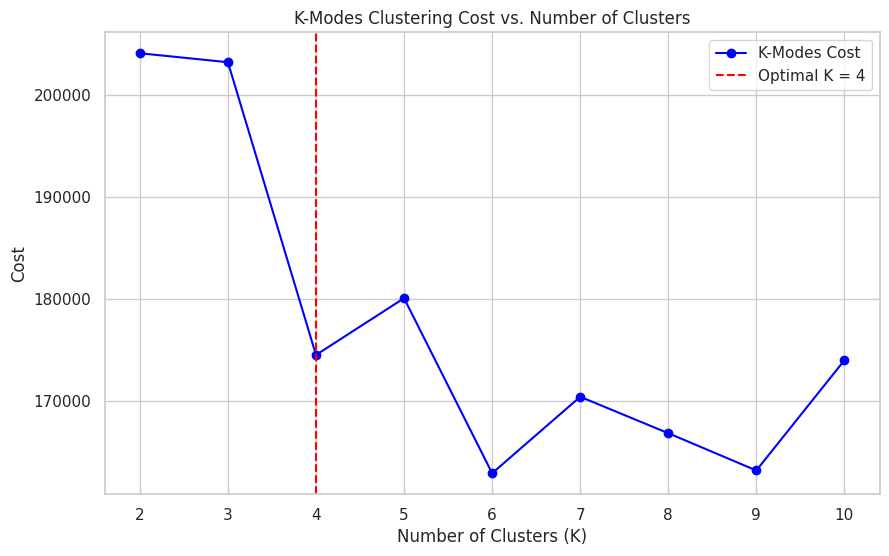

In [9]:
best_kmodes, kmodes_labels, best_k = perform_kmodes_clustering(cluster_train)

In [16]:
def visualize_kmodes_clusters(cluster_train, cluster_labels, best_k):
    print(f"Visualizing K-modes clustering results with k={best_k}...")

    # Convert categorical features to numerical for PCA
    cluster_train_encoded = cluster_train.copy()

    for col in cluster_train_encoded.select_dtypes(include=['object', 'category']).columns:
        le = LabelEncoder()
        cluster_train_encoded[col] = le.fit_transform(cluster_train_encoded[col].astype(str))

    # Use PCA to reduce dimensions for visualization
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(cluster_train_encoded)

    # Plot the clusters
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=cluster_labels,
                          cmap='viridis', alpha=0.7, s=50, edgecolors='w')

    plt.title(f'K-modes Clustering with {best_k} Clusters (PCA Visualization)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.colorbar(scatter, label='Cluster')
    plt.grid(alpha=0.3)
    plt.savefig("kmodes_clusters_visualization.png", dpi=300)
    plt.close()

    # Analyze the characteristics of each cluster
    temp_df = cluster_train.copy()
    temp_df["Cluster"] = cluster_labels

    # Calculate the cluster sizes
    cluster_sizes = temp_df.groupby("Cluster").size()

    # Convert categorical features to their most frequent values
    cluster_summary = temp_df.groupby("Cluster").agg(lambda x: x.value_counts().index[0])

    print("Cluster sizes:")
    print(cluster_sizes)
    print("\nCluster centers (most frequent values per feature):")
    print(cluster_summary)

    # Convert categorical features into label-encoded format for heatmap
    cluster_summary_encoded = cluster_summary.copy()
    for col in cluster_summary_encoded.select_dtypes(include=['object', 'category']).columns:
        le = LabelEncoder()
        cluster_summary_encoded[col] = le.fit_transform(cluster_summary_encoded[col].astype(str))

    # Create a heatmap of the cluster centers
    plt.figure(figsize=(14, 10))
    sns.heatmap(cluster_summary_encoded, annot=True, fmt=".2f", cmap="YlGnBu", linewidths=0.5)
    plt.title(f'Cluster Centers for K-modes with {best_k} Clusters')
    plt.savefig("kmodes_cluster_centers.png", dpi=300)
    plt.close()

    return temp_df

In [19]:
kmodes_results = visualize_kmodes_clusters(cluster_train, kmodes_labels, best_k)

Visualizing K-modes clustering results with k=4...
Cluster sizes:
Cluster
0    30313
1    30106
2    12241
3    15761
dtype: int64

Cluster centers (most frequent values per feature):
        Age Scholarship  Hipertension  Diabetes  Alcoholism   Handcap  \
Cluster                                                                 
0         0           0     -0.495451 -0.278701   -0.177746 -0.137382   
1         0           0     -0.495451 -0.278701   -0.177746 -0.137382   
2        66           0      2.018364 -0.278701   -0.177746 -0.137382   
3        39           0     -0.495451 -0.278701   -0.177746 -0.137382   

         SMS_received  WaitTime_Log  Gender_Encoded  
Cluster                                              
0           -0.685999     -1.029598       -1.359300  
1           -0.685999     -1.029598        0.735673  
2           -0.685999     -1.029598        0.735673  
3            1.457727      0.871603        0.735673  


## HDBSCAN Clustering

In [24]:
def perform_hdbscan_clustering(cluster_train):
    """Perform HDBSCAN clustering with Bayesian optimization for hyperparameters."""
    print("Performing HDBSCAN clustering with hyperparameter optimization...")

    search_space = [
        Integer(50, 500, name='min_cluster_size'),
        Integer(5, 50, name='min_samples')
    ]

    results = []

    # Objective function for Bayesian Optimization
    @use_named_args(search_space)
    def objective(min_cluster_size, min_samples):
        # Fit HDBSCAN with given parameters
        hdb = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples,
                              metric='hamming', cluster_selection_method='eom')
        labels_hdbscan = hdb.fit_predict(cluster_train)

        # Compute noise ratio (higher noise is bad)
        noise_ratio = (labels_hdbscan == -1).sum() / len(labels_hdbscan)

        # Calculate number of clusters (excluding noise)
        num_clusters = len(set(labels_hdbscan)) - (1 if -1 in labels_hdbscan else 0)

        # Skip if all points are noise or only one cluster found
        if num_clusters <= 1:
            score = 1e6  # Heavy penalty for poor clustering
        else:
            # Balance between noise ratio and number of clusters
            score = noise_ratio + 0.1 * (1 / max(num_clusters, 1))  # Avoid division by zero

        # Store results
        results.append({
            "min_cluster_size": min_cluster_size,
            "min_samples": min_samples,
            "noise_ratio": noise_ratio,
            "num_clusters": num_clusters,
            "score": score
        })

        return score  # We want to minimize this

    # Run Bayesian Optimization
    print("Running Bayesian optimization for HDBSCAN parameters...")
    res = gp_minimize(
        func=objective,  # Objective function
        dimensions=search_space,  # Search space
        n_calls=20,  # Number of iterations
        random_state=2025  # Reproducibility
    )

    # Get the best parameters
    best_params = {
        'min_cluster_size': res.x[0],
        'min_samples': res.x[1]
    }

    print(f"Best HDBSCAN parameters: {best_params}")

    # Convert results to DataFrame for better analysis
    results_df = pd.DataFrame(results)

    # Visualization of Hyperparameter Search**
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Plot noise ratio vs parameters
    scatter1 = axes[0].scatter(results_df['min_cluster_size'], results_df['min_samples'],
                               c=results_df['noise_ratio'], cmap='viridis', s=100, alpha=0.7)
    axes[0].set_xlabel('min_cluster_size')
    axes[0].set_ylabel('min_samples')
    axes[0].set_title('Noise Ratio (lower is better)')
    fig.colorbar(scatter1, ax=axes[0])

    # Plot number of clusters vs parameters
    scatter2 = axes[1].scatter(results_df['min_cluster_size'], results_df['min_samples'],
                               c=results_df['num_clusters'], cmap='plasma', s=100, alpha=0.7)
    axes[1].set_xlabel('min_cluster_size')
    axes[1].set_ylabel('min_samples')
    axes[1].set_title('Number of Clusters')
    fig.colorbar(scatter2, ax=axes[1])

    # Plot overall score vs parameters
    scatter3 = axes[2].scatter(results_df['min_cluster_size'], results_df['min_samples'],
                               c=results_df['score'], cmap='coolwarm', s=100, alpha=0.7)
    axes[2].set_xlabel('min_cluster_size')
    axes[2].set_ylabel('min_samples')
    axes[2].set_title('Optimization Score (lower is better)')
    fig.colorbar(scatter3, ax=axes[2])

    # Mark the best parameters
    for ax in axes:
        ax.scatter([best_params['min_cluster_size']], [best_params['min_samples']],
                   marker='*', s=300, color='red', edgecolors='black')

    plt.tight_layout()
    plt.savefig("hdbscan_parameter_optimization.png", dpi=300)
    plt.close()

    # Fit HDBSCAN with the best parameters
    best_hdbscan = hdbscan.HDBSCAN(
        min_cluster_size=best_params['min_cluster_size'],
        min_samples=best_params['min_samples'],
        metric='hamming',
        cluster_selection_method='eom',
        prediction_data=True
    )

    hdbscan_labels = best_hdbscan.fit_predict(cluster_train)

    return best_hdbscan, hdbscan_labels, best_params

In [25]:
best_hdbscan, hdbscan_labels, best_params = perform_hdbscan_clustering(cluster_train)

Performing HDBSCAN clustering with hyperparameter optimization...
Running Bayesian optimization for HDBSCAN parameters...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Best HDBSCAN parameters: {'min_cluster_size': 481, 'min_samples': 8}


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [26]:
best_params

{'min_cluster_size': 481, 'min_samples': 8}

In [31]:
def visualize_hdbscan_clusters(cluster_train, hdbscan_labels, best_params):
    """Visualize the HDBSCAN clustering results."""
    print("Visualizing HDBSCAN clustering results...")

    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(cluster_train)

    # Identify unique clusters
    unique_labels = np.unique(hdbscan_labels)
    num_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)

    # Plot clusters
    plt.figure(figsize=(12, 10))

    # Plot noise points first (if any)
    if -1 in unique_labels:
        noise_mask = (hdbscan_labels == -1)
        plt.scatter(reduced_data[noise_mask, 0], reduced_data[noise_mask, 1],
                   c='lightgray', marker='x', s=40, label='Noise')

    # Plot clustered points
    for cluster_label in unique_labels:
        if cluster_label == -1:  # Skip noise (already plotted)
            continue
        cluster_mask = (hdbscan_labels == cluster_label)
        plt.scatter(reduced_data[cluster_mask, 0], reduced_data[cluster_mask, 1],
                   s=50, alpha=0.7, label=f'Cluster {cluster_label}')

    plt.title(f'HDBSCAN Clustering with {num_clusters} Clusters\n' +
              f'(min_cluster_size={best_params["min_cluster_size"]}, ' +
              f'min_samples={best_params["min_samples"]})')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig("hdbscan_clusters_visualization.png", dpi=300)
    plt.close()

    # Convert cluster labels into the dataframe
    temp_df = cluster_train.copy()
    temp_df["Cluster"] = hdbscan_labels

    # Ensure all categorical data is converted to numeric before calculating mean**
    for col in temp_df.select_dtypes(include=['object', 'category']).columns:
        temp_df[col] = temp_df[col].astype("category").cat.codes  # Convert to numeric codes

    # Compute cluster sizes
    cluster_sizes = temp_df.groupby("Cluster").size()

    # Compute mean values for each cluster
    cluster_summary = temp_df.groupby("Cluster").mean()

    print("HDBSCAN Cluster Sizes:")
    print(cluster_sizes)
    print("\nHDBSCAN Cluster Centers (Mean Values):")
    print(cluster_summary)

    # Heatmap of cluster centers
    plt.figure(figsize=(14, 10))
    sns.heatmap(cluster_summary, annot=True, cmap="YlGnBu", fmt=".2f", linewidths=.5)
    plt.title(f'Cluster Centers for HDBSCAN')
    plt.savefig("hdbscan_cluster_centers.png", dpi=300)
    plt.close()

    return temp_df

In [32]:
hdbscan_results = visualize_hdbscan_clusters(cluster_train, hdbscan_labels, best_params)

Visualizing HDBSCAN clustering results...
HDBSCAN Cluster Sizes:
Cluster
-1     16083
 0       936
 1       524
 2      9530
 3      7409
 4      3495
 5     13640
 6       877
 7       870
 8     33854
 9       569
 10      634
dtype: int64

HDBSCAN Cluster Centers (Mean Values):
               Age  Scholarship  Hipertension  Diabetes  Alcoholism   Handcap  \
Cluster                                                                         
-1       41.286203     0.121495      0.031445  0.146133    0.173733  0.416144   
 0       60.662393     0.005342      1.924365  1.076325    0.491916 -0.137382   
 1        2.328244     0.000000     -0.495451 -0.278701   -0.177746 -0.137382   
 2       35.232109     0.309654     -0.495187 -0.246241   -0.159477 -0.122492   
 3       47.109326     0.069105      0.636428  0.101245   -0.137796 -0.105740   
 4       38.208584     0.025179     -0.427121 -0.256573   -0.126268 -0.084426   
 5       38.853079     0.058651     -0.490659 -0.260557    0.043510  0

## Clustering Analysis for No-Show

In [33]:
def analyze_clusters_for_no_show(train, kmodes_results, hdbscan_results):
    """Analyze how clustering results relate to no-show rates."""
    print("Analyzing clusters in relation to no-show rates...")

    # Add cluster assignments to the training data
    train_with_clusters = train.copy()
    train_with_clusters["KModes_Cluster"] = kmodes_results["Cluster"]
    train_with_clusters["HDBSCAN_Cluster"] = hdbscan_results["Cluster"]

    # Calculate no-show rates by KModes cluster
    kmodes_noshow = train_with_clusters.groupby("KModes_Cluster")["No-show"].agg(["mean", "count"])
    kmodes_noshow.columns = ["No_Show_Rate", "Count"]
    kmodes_noshow = kmodes_noshow.sort_values("No_Show_Rate", ascending=False)

    # Calculate no-show rates by HDBSCAN cluster
    hdbscan_noshow = train_with_clusters.groupby("HDBSCAN_Cluster")["No-show"].agg(["mean", "count"])
    hdbscan_noshow.columns = ["No_Show_Rate", "Count"]
    hdbscan_noshow = hdbscan_noshow.sort_values("No_Show_Rate", ascending=False)

    # Plot no-show rates by cluster
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

    # KModes plot
    kmodes_noshow_plot = kmodes_noshow.reset_index()
    bars1 = ax1.bar(kmodes_noshow_plot["KModes_Cluster"].astype(str),
                   kmodes_noshow_plot["No_Show_Rate"],
                   alpha=0.7)

    # Add count labels on top of bars
    for i, bar in enumerate(bars1):
        count = kmodes_noshow_plot.iloc[i]["Count"]
        ax1.text(bar.get_x() + bar.get_width()/2,
                bar.get_height() + 0.01,
                f'n={count}',
                ha='center', va='bottom',
                fontsize=10)

    ax1.set_xlabel("KModes Cluster")
    ax1.set_ylabel("No-Show Rate")
    ax1.set_title("No-Show Rate by KModes Cluster")
    ax1.set_ylim(0, max(kmodes_noshow_plot["No_Show_Rate"]) * 1.2)
    ax1.grid(alpha=0.3)

    # HDBSCAN plot
    hdbscan_noshow_plot = hdbscan_noshow.reset_index()
    bars2 = ax2.bar(hdbscan_noshow_plot["HDBSCAN_Cluster"].astype(str),
                   hdbscan_noshow_plot["No_Show_Rate"],
                   alpha=0.7)

    # Add count labels on top of bars
    for i, bar in enumerate(bars2):
        count = hdbscan_noshow_plot.iloc[i]["Count"]
        ax2.text(bar.get_x() + bar.get_width()/2,
                bar.get_height() + 0.01,
                f'n={count}',
                ha='center', va='bottom',
                fontsize=10)

    ax2.set_xlabel("HDBSCAN Cluster")
    ax2.set_ylabel("No-Show Rate")
    ax2.set_title("No-Show Rate by HDBSCAN Cluster")
    ax2.set_ylim(0, max(hdbscan_noshow_plot["No_Show_Rate"]) * 1.2)
    ax2.grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig("no_show_rates_by_cluster.png", dpi=300)
    plt.close()

    return train_with_clusters, kmodes_noshow, hdbscan_noshow

In [34]:
train_with_clusters, kmodes_noshow, hdbscan_noshow = analyze_clusters_for_no_show(
    train, kmodes_results, hdbscan_results)

Analyzing clusters in relation to no-show rates...


## Adding clustering Labels back to Train/Test Data

In [38]:
# Train HDBSCAN with prediction enabled
best_hdbscan = hdbscan.HDBSCAN(
    min_cluster_size=best_params['min_cluster_size'],
    min_samples=best_params['min_samples'],
    metric='hamming',
    cluster_selection_method='eom',
    prediction_data=True  # Enables prediction on new data
).fit(cluster_train)

# Assign clusters for training data
hdbscan_train_labels = best_hdbscan.labels_
train["HDBSCAN_Cluster"] = hdbscan_train_labels

# Assign clusters for test data using approximate prediction
hdbscan_test_labels, _ = approximate_predict(best_hdbscan, cluster_test)
test["HDBSCAN_Cluster"] = hdbscan_test_labels

# KModes clustering
kmodes_train_labels = best_kmodes.predict(cluster_train)
train["KModes_Cluster"] = kmodes_train_labels

kmodes_test_labels = best_kmodes.predict(cluster_test)
test["KModes_Cluster"] = kmodes_test_labels

# Print cluster distributions
print("HDBSCAN Train Cluster Distribution:", train["HDBSCAN_Cluster"].value_counts())
print("HDBSCAN Test Cluster Distribution:", test["HDBSCAN_Cluster"].value_counts())
print("KModes Train Cluster Distribution:", train["KModes_Cluster"].value_counts())
print("KModes Test Cluster Distribution:", test["KModes_Cluster"].value_counts())

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


HDBSCAN Train Cluster Distribution: HDBSCAN_Cluster
 8     33854
-1     16083
 5     13640
 2      9530
 3      7409
 4      3495
 0       936
 6       877
 7       870
 10      634
 9       569
 1       524
Name: count, dtype: int64
HDBSCAN Test Cluster Distribution: HDBSCAN_Cluster
 8     8312
-1     4236
 5     3352
 2     2458
 3     1885
 4      873
 7      229
 6      204
 0      198
 1      138
 10     134
 9       87
Name: count, dtype: int64
KModes Train Cluster Distribution: KModes_Cluster
0    30313
1    30106
3    15761
2    12241
Name: count, dtype: int64
KModes Test Cluster Distribution: KModes_Cluster
0    7467
1    7459
3    4064
2    3116
Name: count, dtype: int64


# Correlations

In [40]:
train_corr = train.copy()
train_corr.drop(columns=["WaitTime", 'PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay'], inplace=True)

In [42]:
corr_matrix = train_corr.corr(numeric_only=True)

In [43]:
print("Correlation with 'No-show':\n", corr_matrix["No-show"].sort_values(ascending=False))

Correlation with 'No-show':
 No-show                           1.000000
WaitTime_Log                      0.264772
SMS_received                      0.127649
KModes_Cluster                    0.066263
NB_ITARARÉ                        0.027286
NB_SANTOS DUMONT                  0.023319
NB_JESUS DE NAZARETH              0.017599
NB_ILHA DO PRÍNCIPE               0.014085
NB_SANTA CECÍLIA                  0.011910
NB_SANTA CLARA                    0.011646
NB_ANDORINHAS                     0.010530
NB_CARATOÍRA                      0.010297
NB_ILHAS OCEÂNICAS DE TRINDADE    0.009451
NB_SÃO JOSÉ                       0.007954
NB_GURIGICA                       0.006878
NB_MARUÍPE                        0.006249
NB_CENTRO                         0.005601
NB_MARIA ORTIZ                    0.004984
NB_PARQUE MOSCOSO                 0.004760
NB_ROMÃO                          0.004640
NB_PRAIA DO SUÁ                   0.004339
NB_BENTO FERREIRA                 0.004207
NB_ILHA DAS CAIEIRAS     

# Saving Final Data

In [45]:
train_final = train.drop(columns=["WaitTime", 'Gender', 'ScheduledDay', 'AppointmentDay'])
test_final = test.drop(columns=["WaitTime", 'Gender', 'ScheduledDay', 'AppointmentDay'])
test_final.head()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,WaitTime_Log,Gender_Encoded,ScheduledDay_Month,ScheduledDay_Weekday,AppointmentDay_Month,AppointmentDay_Weekday,NB_ANDORINHAS,NB_ANTÔNIO HONÓRIO,NB_ARIOVALDO FAVALESSA,NB_BARRO VERMELHO,NB_BELA VISTA,NB_BENTO FERREIRA,NB_BOA VISTA,NB_BONFIM,NB_CARATOÍRA,NB_CENTRO,NB_COMDUSA,NB_CONQUISTA,NB_CONSOLAÇÃO,NB_CRUZAMENTO,NB_DA PENHA,NB_DE LOURDES,NB_DO CABRAL,NB_DO MOSCOSO,NB_DO QUADRO,NB_ENSEADA DO SUÁ,NB_ESTRELINHA,NB_FONTE GRANDE,NB_FORTE SÃO JOÃO,NB_FRADINHOS,NB_GOIABEIRAS,NB_GRANDE VITÓRIA,NB_GURIGICA,NB_HORTO,NB_ILHA DAS CAIEIRAS,NB_ILHA DE SANTA MARIA,NB_ILHA DO BOI,NB_ILHA DO FRADE,NB_ILHA DO PRÍNCIPE,NB_ILHAS OCEÂNICAS DE TRINDADE,NB_INHANGUETÁ,NB_ITARARÉ,NB_JABOUR,NB_JARDIM CAMBURI,NB_JARDIM DA PENHA,NB_JESUS DE NAZARETH,NB_JOANA D´ARC,NB_JUCUTUQUARA,NB_MARIA ORTIZ,NB_MARUÍPE,NB_MATA DA PRAIA,NB_MONTE BELO,NB_MORADA DE CAMBURI,NB_MÁRIO CYPRESTE,NB_NAZARETH,NB_NOVA PALESTINA,NB_PARQUE INDUSTRIAL,NB_PARQUE MOSCOSO,NB_PIEDADE,NB_PONTAL DE CAMBURI,NB_PRAIA DO CANTO,NB_PRAIA DO SUÁ,NB_REDENÇÃO,NB_REPÚBLICA,NB_RESISTÊNCIA,NB_ROMÃO,NB_SANTA CECÍLIA,NB_SANTA CLARA,NB_SANTA HELENA,NB_SANTA LUÍZA,NB_SANTA LÚCIA,NB_SANTA MARTHA,NB_SANTA TEREZA,NB_SANTO ANDRÉ,NB_SANTO ANTÔNIO,NB_SANTOS DUMONT,NB_SANTOS REIS,NB_SEGURANÇA DO LAR,NB_SOLON BORGES,NB_SÃO BENEDITO,NB_SÃO CRISTÓVÃO,NB_SÃO JOSÉ,NB_SÃO PEDRO,NB_TABUAZEIRO,NB_UNIVERSITÁRIO,NB_VILA RUBIM,HDBSCAN_Cluster,KModes_Cluster
79114,2777971638965,5606425,25,0,0,0,0,0,0,0,3.295837,0,4,Wednesday,5,Tuesday,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,5,0
5391,5697299946278,5670278,73,0,1,0,0,0,1,0,1.386294,0,5,Friday,5,Tuesday,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,-1,0
90675,27213716577899,5768693,61,0,1,0,0,0,0,0,0.000000,1,6,Friday,6,Friday,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,8,2
41146,96175674833743,5743936,29,0,0,0,0,0,0,0,0.000000,1,5,Monday,5,Tuesday,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,8,1
27416,595893781329,5500825,26,0,0,0,0,0,1,0,4.143135,0,3,Tuesday,5,Tuesday,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,

In [46]:
train_final.to_csv("train_processed_v4.csv", index=False)
test_final.to_csv("test_processed_v4.csv", index=False)